# Creating and Modifying ASE Crystals

This notebook contains a couple of methods which can be useful for the modification of crystals generated with the `ase` package. These crytals can then also be written as a text file with typical LAMMPS formatting.

Note that the modification steps below may not work together. It is advised to always visualize the resulting crystal if possible, either within the notebook using matplotlib or `ase`'s `ase.visualize.view`.

In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import ase

from ase.spacegroup import crystal as ase_crystal
import numpy as np

from atomtoolbox import misc
import atomtoolbox as atb

import copy, collections
from scipy import stats

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## 1. Create A Crystal

In [2]:
a0 = 3.52 #[Ang]
supercell = (10,10,10)
atoms = ase_crystal('Ni', [(0,0,0)], spacegroup=225, cellpar=[a0, a0, a0, 90, 90, 90],
                     size=supercell)
print("Number of atoms: ",atoms.positions.shape[0])

Number of atoms:  4000


## 2. Compute Thermal Vacancy Concentration

In [3]:
T = 1500. #[K]
Hf = 1.403
Sf = 3.16 

c_vac = atb.thermal_vacancy_concentration(Hf, Sf, T)
print("T = {} K, Hf = {} eV, Sf = {} => c_vac = {:.3g}".format(T, Hf, Sf, c_vac))

T = 1500.0 K, Hf = 1.403 eV, Sf = 3.16 => c_vac = 0.000456


## 3. Introducing Vacancies in a Crystal

atoms  4000
atoms_vac  3600


<IPython.core.display.Javascript object>


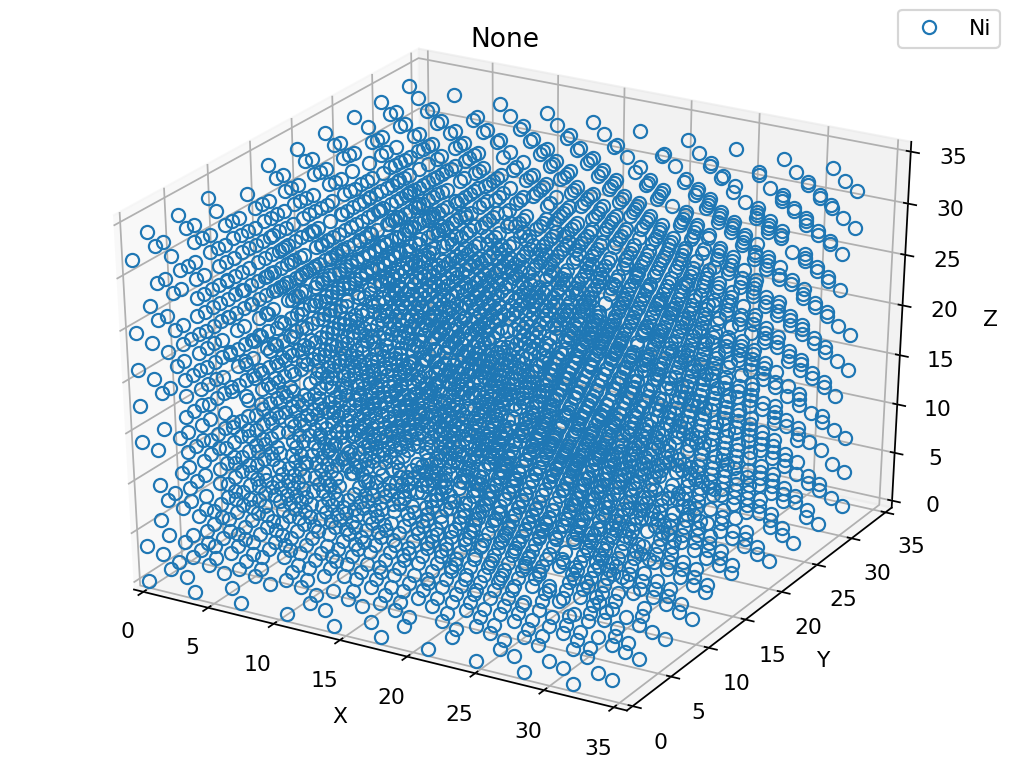

In [4]:
atoms_vac = atb.introduce_vacancies(atoms, c_vac=.1, N_vac=None, select="Ni", 
                        verbose=False)

print("atoms ",atoms.positions.shape[0])
print("atoms_vac ",atoms_vac.positions.shape[0])
atb.show_atoms(atoms=atoms_vac)

## 4. Chemically Disordering A Crystal

[('Ni', 3200), ('Al', 800)]


<IPython.core.display.Javascript object>


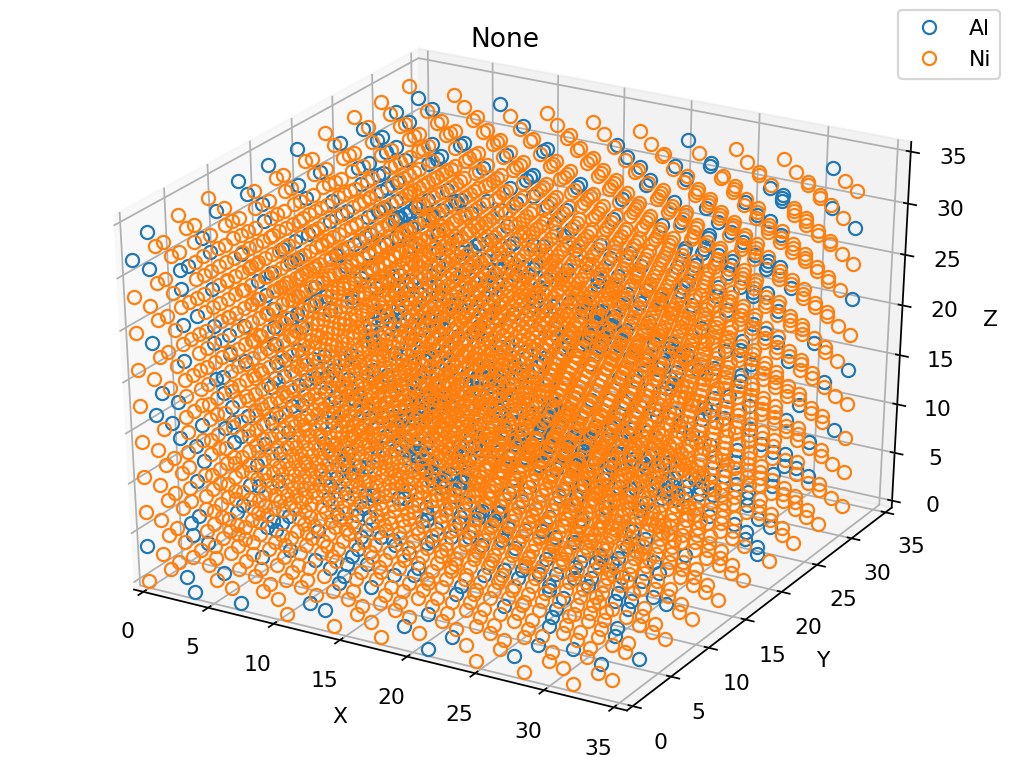

In [5]:
concentrations = {"Al":.2}
atoms_gamma = atb.create_chemical_disorder(atoms,concentrations)

print(collections.Counter(atoms_gamma.get_chemical_symbols()).most_common())
atb.show_atoms(atoms=atoms_gamma)

## 5. Introducing a Precipitate into a Host Crystal

Inserting L12 prectipitate with r = 10.0 A at 17.6 A, 17.6 A, 17.6


<IPython.core.display.Javascript object>


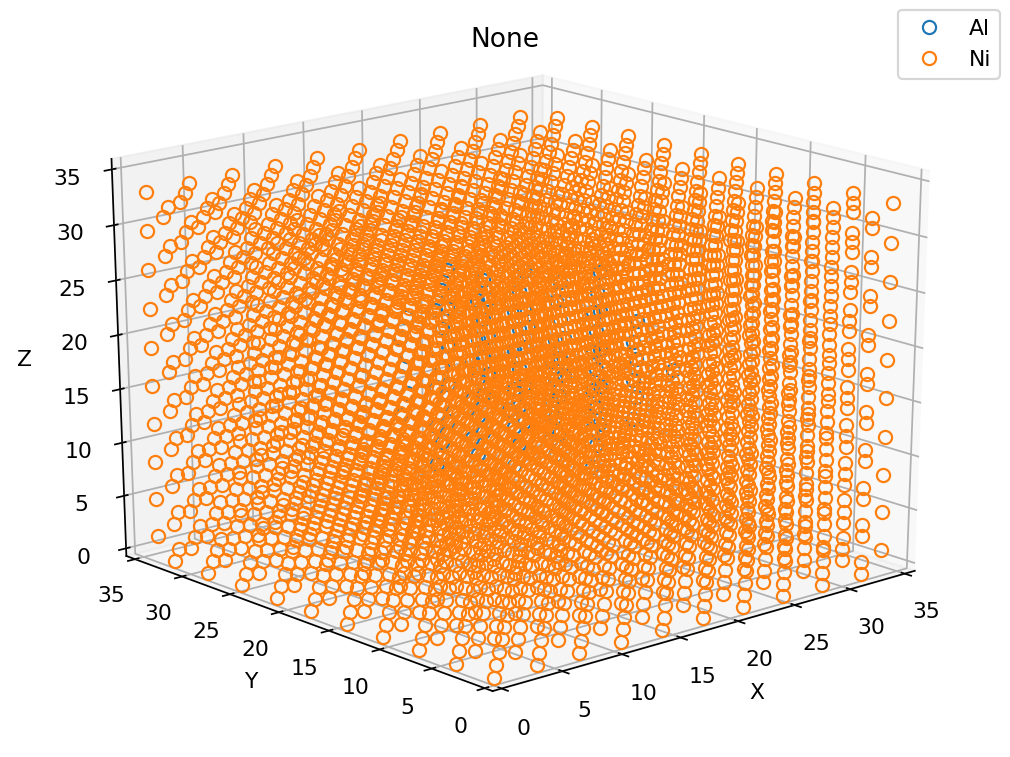

structure processed:


<IPython.core.display.Javascript object>


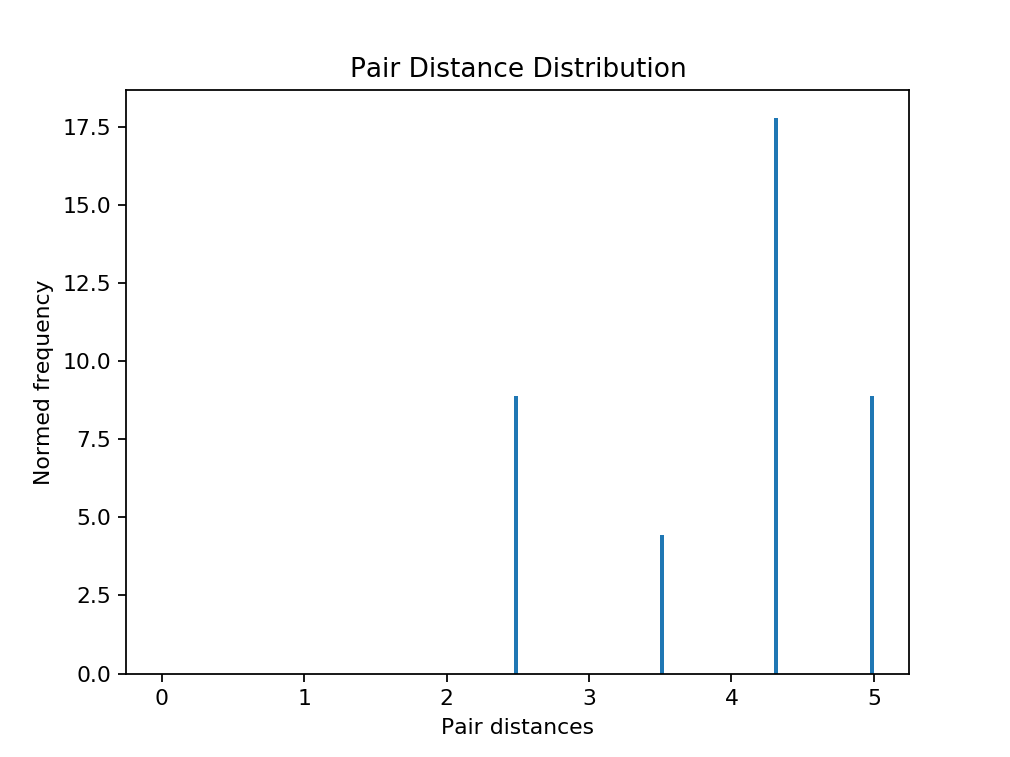

smallest pair distances:  [ 2.48901587  2.48901587  2.48901587  2.48901587  2.48901587  2.48901587
  2.48901587  2.48901587  2.48901587  2.48901587]
largest pair distances:  [ 4.97803174  4.97803174  4.97803174  4.97803174  4.97803174  4.97803174
  4.97803174  4.97803174  4.97803174  4.97803174]


In [6]:
ppt_pos = (.5,.5,.5) #[fractional]
ppt_r = 10. #[Ang]

a0 = 3.52
L12 = atb.L12Factory()
atoms_gamma_prime = L12(directions=[[1,0,0],[0,1,0],[0,0,1]],
                          symbol=["Al","Ni"],pbc=(1,1,1),latticeconstant=a0)

atoms_ppt = atb.insert_spherical_precipitate(atoms, atoms_gamma_prime, ppt_pos=ppt_pos, 
                                         ppt_r=ppt_r, verbose=True, shift_type="origin")
atb.show_atoms(atoms=atoms_ppt)

all_r, _ = atb.get_r_and_dens_values([atoms_ppt.get_positions(wrap=True)], [atoms_ppt.get_cell()], 
                                            [atoms_ppt.get_chemical_symbols()], 5, None,)

all_r = all_r[0]
_range = (0,5)
bins = 200
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_r,bins=bins,normed=True,range=_range)
ax.set_ylabel("Normed frequency")
ax.set_xlabel("Pair distances")
ax.set_title("Pair Distance Distribution")
plt.show()

print("smallest pair distances: ",all_r[np.argsort(all_r)[:10]])
print("largest pair distances: ",all_r[np.argsort(all_r)[-10:]])

## 6. Generating a LAMMPS `*.lammpstrj` Format Trajectory File

In [7]:
write_atoms = atoms_gamma

Nrattle = 5
rattle_rvs = [stats.norm(loc=0, scale=0.005)]
rpositions, Natoms, cells, species = atb.rattle_crystal_multiple_rvs(Nrattle, rattle_rvs,\
                                write_atoms)

path = "test.lammpstrj"

atb.create_LAMMPS_traj(path, rpositions, Natoms, species, cells, verbose=True)

Writing to test.lammpstrj
